# Logistic Regression with L1 regularization for sparse recovery of the dysregulated pathways in our synthetic datasets

In [2]:
%pylab inline
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split, cross_val_score, KFold

import pickle
from matplotlib_venn import venn3, venn3_circles, venn2

Populating the interactive namespace from numpy and matplotlib


### I. Load Dataset

In [3]:
dataset = pd.read_csv('/Users/alex/Documents/proteomics/synthetic_proteomics/generated_data/ludwig_svd_normals/hsa04110_inbiomap_exp.csv', index_col=0)
dataset.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
hsa04110,0.0,0.014856,0.264810,0.109797,-0.976005,0.173769,0.0,0.285756,0.288839,-0.231566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,0.0,-0.228736,0.089442,0.339065,-0.597546,0.040049,0.0,-0.098450,0.073976,-0.494193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.715740,-0.143526,-0.480106,0.125846,0.284645,-0.0,0.021132,-0.115910,-0.016950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.383979,0.359009,0.394243,-0.387827,-0.281805,0.0,-0.922308,0.340674,-0.278771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,0.0,-0.023037,0.196800,-0.292508,0.165186,0.105207,0.0,-0.521385,-0.194466,-0.234121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### II. Extract Labels

In [4]:
labels = dataset.index.values
labels

array(['hsa04110', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'hsa04110', 'negative', 'negative',
       'hsa04110', 'negative', 'hsa04110', 'hsa04110', 'hsa04110',
       'negative', 'hsa04110', 'negative', 'negative', 'hsa04110',
       'negative', 'hsa04110', 'negative', 'negative', 'negative',
       'hsa04110', 'negative', 'negative', 'hsa04110', 'negative',
       'negative', 'hsa04110', 'hsa04110', 'negative', 'negative',
       'negative', 'negative', 'hsa04110', 'negative', 'negative',
       'negative', 'hsa04110', 'hsa04110', 'negative', 'negative',
       'negative', 'negative', 'hsa04110', 'hsa04110', 'negative',
       'hsa04110', 'hsa04110', 'hsa04110', 'negative', 'negative',
       'negative', 'hsa04110', 'negative', 'hsa04110', 'negative',
       'hsa04110', 'hsa04110', 'hsa04110', 'hsa04110', 'hsa04110',
       'hsa04110', 'hsa04110', 'hsa04110', 'negative', 'negative',
       'hsa04110', 'negative', 'negative', 'hsa04110', 'hsa041

### III. L1-regularized Sparse Logistic Regression

In [17]:
classifier = LogisticRegression(solver='liblinear', penalty='l1', C=100)
classifier = classifier.fit(dataset.values, labels)
coefs = pd.DataFrame(classifier.coef_, columns=dataset.columns)
features = coefs.ix[0, coefs.loc[0].nonzero()[0].tolist()].index.tolist()

/Users/alex/Documents/proteomics/venv/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


### IV. Examine Results

In [18]:
classifier.classes_

array(['hsa04110', 'negative'], dtype=object)

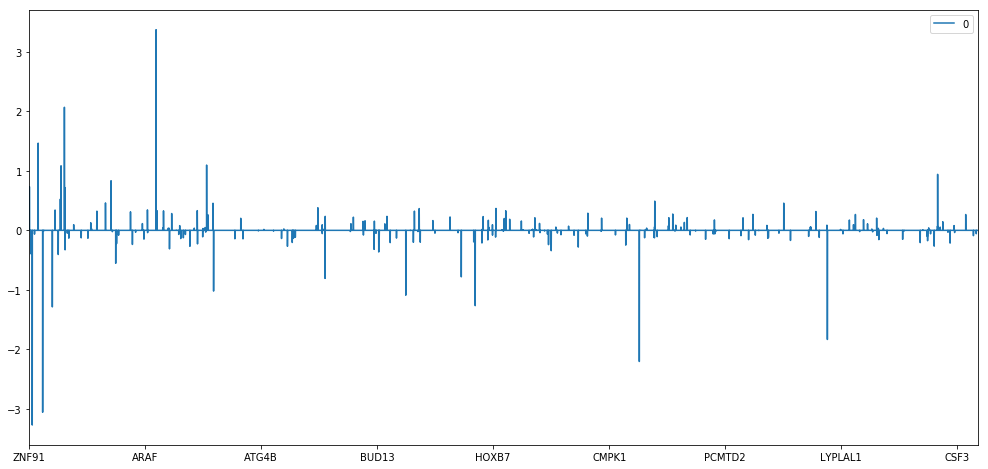

In [19]:
pd.DataFrame(classifier.coef_, columns=dataset.columns).transpose().plot(figsize=(17,8))

In [20]:
pathways_df = pd.read_pickle('/Users/alex/Documents/proteomics/synthetic_proteomics/data_generation/KEGG_df.filtered.with_correlates.pickle')

In [21]:
genes, correlates = pathways_df.loc[pd.IndexSlice[:, :, ['hsa04110']],['genes', 'correlates']].values[0]
correlates = correlates.tolist()
# pathways_df.loc[pd.IndexSlice[:, :, ['hsa04810']],['genes', 'correlates']]

/Users/alex/Documents/proteomics/venv/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


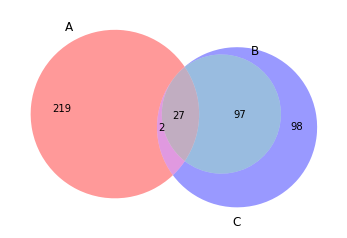

In [22]:
venn3([set(features), set(genes), set(genes) | set(correlates)])

### V. Ludwig's Softmax Loss experiments

In [22]:
def softmax_loss(X, y, W):
    # TODO: make this work with nopython=True
    assert len(X.shape) == 2
    n, d = X.shape
    assert y.shape == (n,)
    assert len(W.shape) == 2
    assert W.shape[1] == d
    c = W.shape[0]
    # TODO: check that elements in y are in the correct range
    
    # TODO: replace with transpose_b=True ?
    prod = np.dot(X, W.transpose())
    row_max = np.amax(prod, axis=1)
    prod_normalized = prod - np.expand_dims(row_max, 1)
    exp_prod = np.exp(prod_normalized)
    denom = np.sum(exp_prod, axis=1)
    
    total_loss = 0.0
    for ii in range(n):
        cur_y = y[ii]
        cur_x = X[ii,:]
        total_loss += prod_normalized[ii, cur_y] - math.log(denom[ii])
    return -total_loss / n

In [23]:
labeler = LabelEncoder()
labeler.fit(labels)
labels = labeler.transform(dataset.index.tolist())
y = labels
y

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0])

In [24]:
softmax_loss(dataset.values, y, np.vstack([-coefs.values, coefs.values]))

0.036948344162044962